# Convolutional Neural Network Denoising: Computed Tomography
---
*Authors: Nathan R. Huber and Andrew D. Missert*

This tutorial demonstrates the application of deep convolutional neural networks (CNNs) for reducing noise in computed tomography (CT) images. By leveraging the prior information contained in many examples of low-noise and high-noise images, CNN denoising can reduce noise in CT images while maintaining high levels of anatomic detail.

This tutorial presents a simple overview of the training procedure for illustrative purposes, and is not intended to produce an optimal result. No Python coding experience or machine learning knowledge is necessary or assumed.

In [0]:
#Cell 1

%tensorflow_version 1.x 
import tensorflow as tf

from tensorflow import keras as ker
from scipy import ndimage, misc
import numpy as np
import matplotlib.pyplot as plt
import time
import os


## Loading Data

In order to train the CNN, we need many examples of low-noise and high-noise images. We must also be careful to evaluate the denoising performance on different images than those use for training. This can be done by partitioning the data into **training** examples, which are used to optimize the CNN parameters, **validation** examples, which are used to monitor the optimization process, and **testing** examples, which are used to check performance.

The data used in this tutorial is made available through the AAPM and Mayo Clinic Low Dose CT Grand Challenge (Medical Physics 44(10), 2017). Each training example consists of a pair of images: the input, which is a simulated 25% dose CT image, and the target, which is the corresponding routine dose CT image.

![alt text](https://drive.google.com/uc?id=1dBzBOk1ZejqZ8as9cioyXB--8X0z0SST)



In [0]:
#Cell 2

# Load data for tutorial from github
if not os.path.exists('./tutorial_data'):
  !git clone https://github.com/nhuber314/tutorial_data.git
  

Cloning into 'tutorial_data'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 20 (delta 1), reused 6 (delta 1), pack-reused 12
Unpacking objects: 100% (20/20), done.


In [0]:
#Cell 3

if not os.path.exists('./data'):
    !cp tutorial_data/data.tgz ./
    !tar -xzvf data.tgz
    assert os.path.exists('./data')

# Load the training data array, which is used to update CNN weights
# This arraay contains 8000 30x30 CT image patches
train_input = np.load('./data/train_input.npy')
train_target = np.load('./data/train_target.npy')
train_target.shape

# Load the validation data array, which is used to monitor for overfitting
# This array contains 1000 30x30 image patches
val_input = np.load('./data/val_input.npy')
val_target = np.load('./data/val_target.npy')

# Load the testing data, which is used to validate the model performance
# This array contains 5 512x512 images
test_input = np.load('./data/test_input.npy')
test_target = np.load('./data/test_target.npy')

# Load some examples images from a more advanced denoising CNN for comparison
test_example = np.load('./data/test_input_denoised.npy') 
 
print('Data loading completed.')

./data/
./data/test_input.npy
./data/test_input_denoised.npy
./data/test_target.npy
./data/test_target_denoised.npy
./data/train_input.npy
./data/train_target.npy
./data/val_input.npy
./data/val_target.npy
Data loading completed.


In [0]:
#Cell 4

# This is a helper function that plots images using typical CT windows
def ctshow(img, window='soft_tissue'):

  # Define some specific window settings here
  if window == 'soft_tissue':
    ww = 400
    wl = 40
  elif window == 'bone':
    ww = 2500.
    wl = 480.
  elif window == 'lung':
    ww = 1500
    wl = -600
  else:
    ww = 6.0 * img.std()
    wl = img.mean()

  # Plot image on clean axes with specified window level
  vmin = wl - ww // 2
  vmax = wl + ww // 2
  plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
  plt.xticks([])
  plt.yticks([])

  return

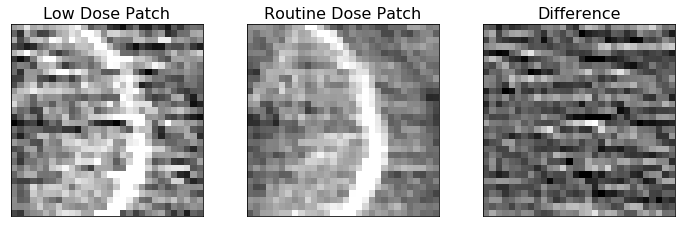

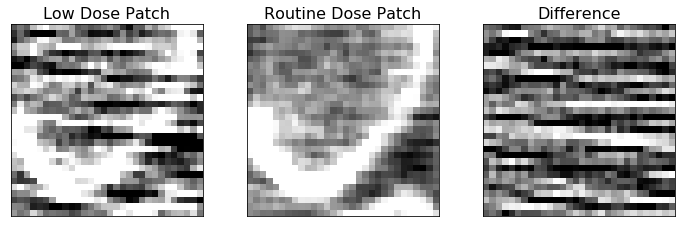

In [0]:
#Cell 5

# Get a few examples of training patches
image_examples = [3, 16, 36]
window = 'soft_tissue'

for row in range(2):

  plt.figure(figsize=(12, 12))
  nexample = image_examples[row]

  # Simulated low-dose example
  plt.subplot(3, 3, 1+row*3)
  plt.title('Low Dose Patch', fontsize=16)
  ctshow(train_input[nexample, :, :, 0], window=window)

  # Simulated routine-dose example
  plt.subplot(3, 3, 2+row*3)
  plt.title('Routine Dose Patch', fontsize=16)
  ctshow(train_target[nexample, :, :, 0], window=window)
  plt.subplot(3, 3, 3+row*3)

  # Difference between low-dose and routine-dose to visualize CT noise
  plt.title('Difference', fontsize=16)
  ctshow(train_target[nexample, :, :, 0] - train_input[nexample, :, :, 0],
           window=window)



## Building Keras model:

CNNs are simply mathematical functions that consist of repeated convolution operations. Each convolutional layer convolves multiple filters (kernels) over the input images. The values used for each filter are free parameters that are adjusted during the training procedure. A simple non-linear activation function is also applied between the convolutional layers.

![](https://drive.google.com/uc?id=1TcL3zaVmIUaOzC2toESDl0a-wTsJFNL5)

Provided below is a basic model for CNN denoising containing convolutional layers and ReLU activation layers. Each layer operates on the output of the previous layer.

In [0]:
#Cell 6

# This specifies the number of convolutonal layers in the model
n_layers = 6 

# This specifies the number of convolutional filters in each convolutional layer
filters = 64 

# This specifies the size of the filter in each convolutional layer
kernel_size = (3, 3)

# This specifies the number of pixels the filter translates at each step
strides = (1, 1) 

# This specifies the non-linear function applied after each convolutionaly layer
activation = 'relu'


# This function builds the model according to the parameters set above
def build_model():

    # The input tensor image can have arbitrary spatial extent, but just
    # one channel for the grayscale CT images
    xin = ker.layers.Input(shape=(None, None, 1), name='input_CT_images')
    
    # We need to define a preprocessing layer to rescale the CT image pixel 
    # values
    shift_mean = train_input.mean()
    rescale = train_input.std()
    x = ker.layers.Lambda(
        lambda x: (x - shift_mean) / rescale,
        name='normalization')(xin)
    
    # This loop adds each convolutional layer
    for i in range(n_layers - 1):
        x = ker.layers.Conv2D(
          filters=filters,
          kernel_size=kernel_size,
          strides=strides,
          padding='same')(x)
        x = ker.layers.Activation(activation)(x)

    # This final layer has just one feature map corresponding to the output
    # image
    x = ker.layers.Conv2D(
        filters=1,
        kernel_size=kernel_size,
        strides=strides,
        padding='same')(x)
    
    # Here we rescale the output to typical CT number range. 
    xout = ker.layers.Lambda(
        lambda x: (x * rescale) + shift_mean,
        name='output_CT_images')(x)
    
    # We define the model by specifying the inputand output tensors
    model = ker.Model(inputs=xin, outputs=xout, name="CT_denoiser")
    return model



denoising_model = build_model()
denoising_model.summary()



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "CT_denoiser"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_CT_images (InputLayer) [(None, None, None, 1)]   0         
_________________________________________________________________
normalization (Lambda)       (None, None, None, 1)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    640       
_________________________________________________________________
activation (Activation)      (None, None, None, 64)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
activation_1 (Activation)    (None, None, None, 64)    0         
________________________________________

## Optimization: Training the network

Take a moment to appreciate the number of trainable parameters listed in the model summary above. These parameters start off randomly initialized and must be optimized to perform a denoising task.

For this part of the tutorial, these parameters will be optimized with one goal in mind: to minimize the mean-squared-error (MSE) difference between the CNN output images and the low-noise target images.

We can train the model provided the datasets we previously loaded. When running on Google Colab, you will want to utilize a GPU for this optimization procedure. Click **Runtime** above, then **Change Runtime Type** in the drop down menu, finally select **GPU** under hardware accelerator. It should take the GPU under three minutes to train the model with default parameters.

In [0]:
#Cell 7

# This sets the number of iterations through the training data
epochs = 15 

# This sets the number of images patches used to calcualte a single 
# parameter update.
batch_size = 32        

# This is a scaling factor that affects the magnitued of each update step
learning_rate = 0.0001  

# The optimizer manages how the parameters are updated from each gradient 
# calculation
optimizer = ker.optimizers.Adam(lr=learning_rate)

# As the training progresses, we'll monitor the network output and performance
# metrics
progress_example = 2
buffer = 128
progress_ims = []

def train(loss_function, model):

    model.compile(optimizer=optimizer, loss=loss_function)

    # As the training progresses, we'll monitor the network output and performance
    # metrics. Some related variables are initialized here
    example_input = test_input[[3], ...]
    edge_buffer = 128
    progress_ims = []
    progress_val = []

    for epoch in range(epochs):  

      # Evaluate model on reserved data
      val_loss = model.evaluate(val_input, val_target)
      example_output = model.predict(example_input)
      example_img = example_output[0, edge_buffer:-edge_buffer,
                                edge_buffer:-edge_buffer, 0]
      progress_ims.append(example_img)
      progress_val.append(val_loss)
    
      # Update model weights using training data
      istart = 0
      while istart < (len(train_input) - batch_size):
          x = train_input[istart:istart + batch_size]
          y = train_target[istart:istart + batch_size]
          model.train_on_batch(x=x, y=y)
          istart += batch_size

    progress_ims = np.stack(progress_ims, axis=0)

    print('Training phase complete.')
    return model, progress_ims, progress_val


# Now run the training fuction to obtain the trained model and performance at
# intermediate steps
denoising_model, progress_ims, progress_val = train(loss_function='mse', model=denoising_model)

1000/1000 [==============================] - 0s 233us/sample - loss: 749.6117
Training phase complete.


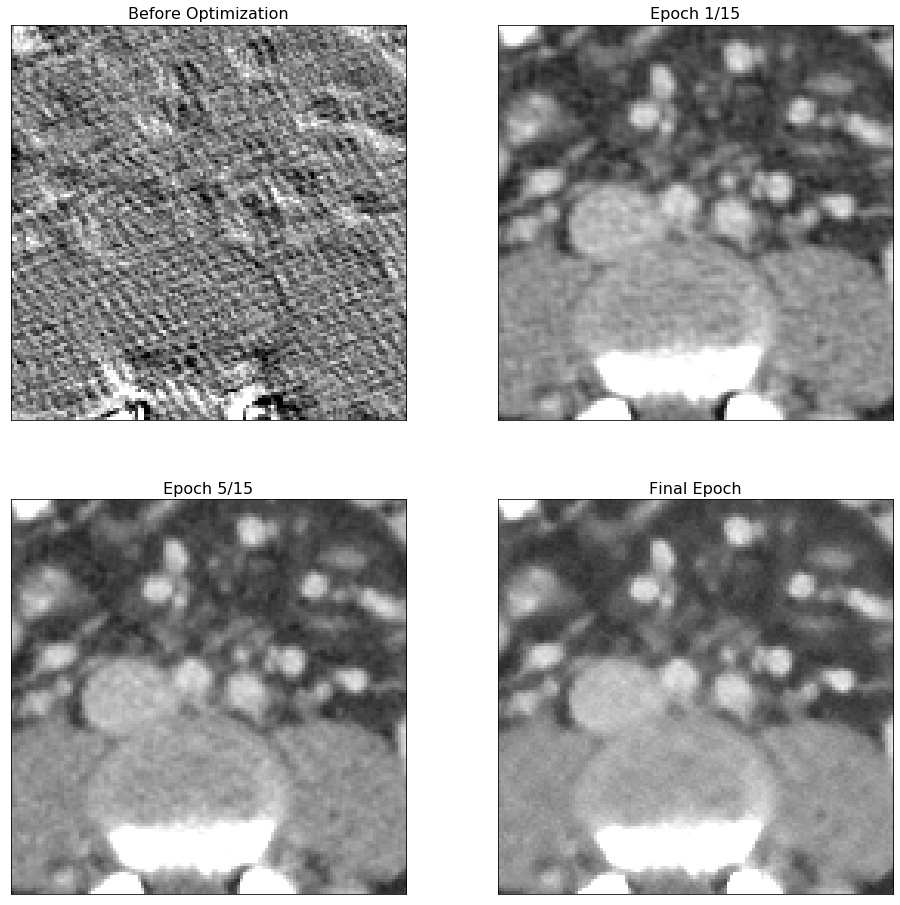

In [0]:
#Cell 8

# Here we show some example images from different epochs in the training
# procedure.

plt.figure(figsize=(16, 16))

plt.subplot(2, 2, 1)
plt.title('Before Optimization', fontsize=16)
ctshow(progress_ims[0, :, :], window='variable')

plt.subplot(2, 2, 2)
plt.title('Epoch %d/%d' %(1, epochs), fontsize=16)
ctshow(progress_ims[1, :, :], window='soft_tissue')

plt.subplot(2, 2, 3)
plt.title('Epoch %d/%d' %(5, epochs), fontsize=16)
ctshow(progress_ims[2, :, :], window='soft_tissue')

plt.subplot(2, 2, 4)
plt.title('Final Epoch', fontsize=16)
ctshow(progress_ims[-1, :, :], window='soft_tissue')

### Inference: Testing the network

Now that the network is fully trained, we can apply to our CNN in inference mode to the reserved testing data to check the performance. Since all CNN parameters are fixed at this point, the processing time for this phase is typically very fast.





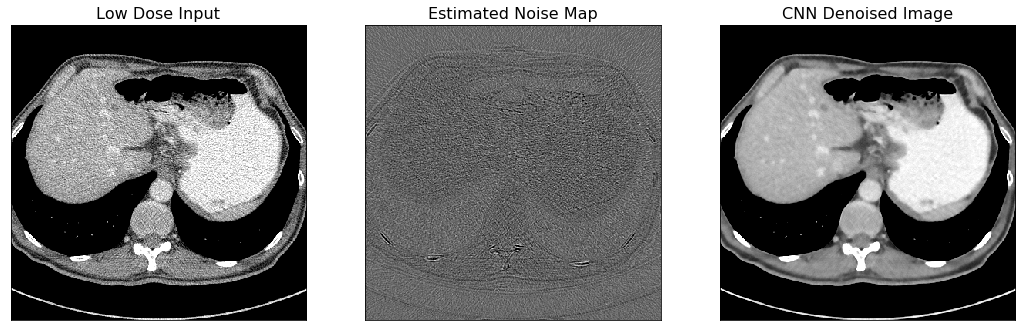

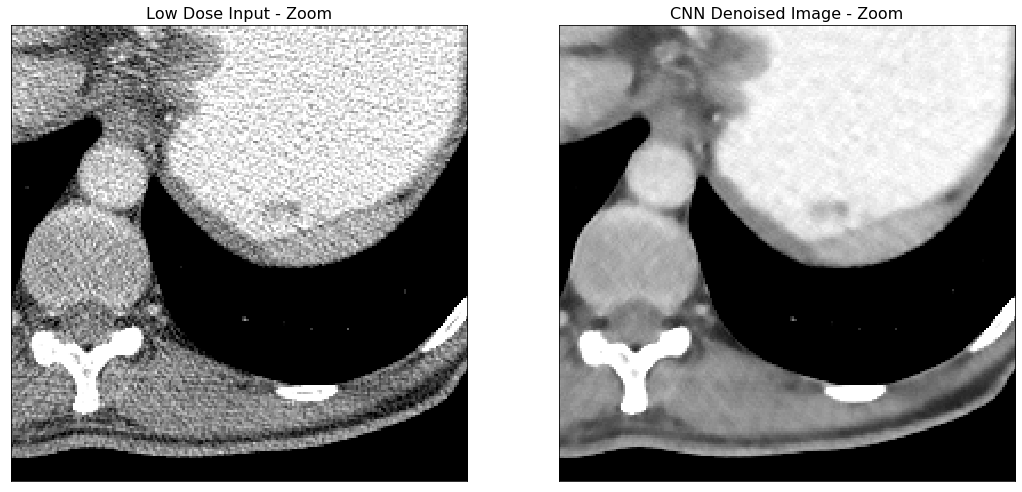

In [0]:
#Cell 9

# Display an example input image, the denoised image, and the difference
nexample = 1
CNNout = denoising_model.predict(test_input, batch_size=1)

plt.figure(figsize=(18, 9))

plt.subplot(1, 3, 1)
plt.title('Low Dose Input', fontsize=16)
ctshow(test_input[nexample, :, :, 0])

plt.subplot(1, 3, 2)
plt.title('Estimated Noise Map', fontsize=16)
ctshow(test_input[nexample, :, :, 0] - CNNout[nexample, :, :, 0])

plt.subplot(1, 3, 3)
plt.title('CNN Denoised Image', fontsize=16)
ctshow(CNNout[nexample, :, :, 0])


# Same as above, but with a different field of view
plt.figure(figsize=(18, 9))

plt.subplot(1, 2, 1)
plt.title('Low Dose Input - Zoom', fontsize=16)
ctshow(test_input[nexample, 150:350, 150:350, 0])

plt.subplot(1, 2, 2)
plt.title('CNN Denoised Image - Zoom', fontsize=16)
ctshow(CNNout[nexample, 150:350, 150:350, 0])

## Feature loss using VGG16:

The choice of loss function has a substantial impact on the denoising result. Our initial choice of loss function is just the mean-squared-error (MSE), which is a pixel-per-pixel comparison between the denoised image and the routine-dose reference. This loss function may be supplemented by functions that perform non-local comparisons of image features. One such approch is feature loss, which computes the MSE between feature maps of a pre-trained image classification network. Here we demonstrate this loss using the VGG16 network trained on ImageNet data. 


![alt text](https://drive.google.com/uc?id=1uDF-Psv8MulPX-vJx24hllzaiM1jsBkK)


In [0]:
#Cell 10

# Load the pre-trained VGG model from Keras
modelVGG = ker.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, pooling=None)
modelVGG.summary()

58892288/58889256 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [0]:
#Cell 11

# Here we specify which layers we will use to use to define the feature loss 
# Then we build a model that outputs the feature maps of these layers
feature_loss_layers = [
    'block3_conv3'
]

def get_VGG_features(feature_layers):

  # VGG expects normalized inputs, so we need to do some preprocessing to the CT
  # images first
  stack_layer = ker.layers.Lambda(lambda x: tf.tile(x, [1, 1, 1, 3]), name='CT_stack')
  preproc_layer = ker.layers.Lambda(lambda x: (x + 1024.0)/1500., name='CT_preprocess')
  clip_layer = ker.layers.Lambda(lambda x: tf.clip_by_value(x, 0.0, 1.0), name='CT_clip')

  # Get VGG input and add preprocesing layers
  inputs = ker.layers.Input(shape=(None, None, 1))
  x = stack_layer(inputs)
  x = preproc_layer(x)
  x = clip_layer(x)

  # Re-connect subsequent layers, and add to output if layer was specified
  # for perceptual loss
  outputs = []
  for layer in modelVGG.layers[1:]:
    x = layer(x)
    if layer.name in feature_loss_layers:
      print('Adding layer {} to output'.format(layer.name))
      outputs.append(x)

  vgg_feature_model = ker.Model(inputs, outputs)
  return vgg_feature_model

feature_model = get_VGG_features(feature_loss_layers)
feature_model.trainable = False
feature_model.summary()

Adding layer block3_conv3 to output
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
CT_stack (Lambda)            (None, None, None, 3)     0         
_________________________________________________________________
CT_preprocess (Lambda)       (None, None, None, 3)     0         
_________________________________________________________________
CT_clip (Lambda)             (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D

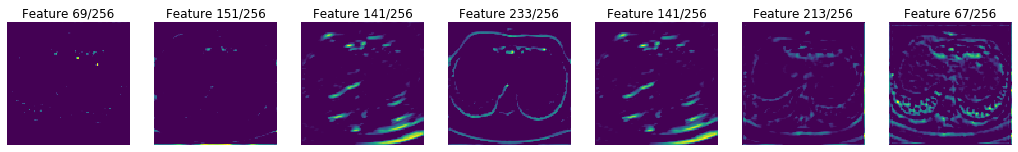

In [0]:
#Cell 13

# Run an example CT image through VGG model and plot a random selection of 
# feature maps
y = feature_model.predict(test_input[[1]])
plt.figure(figsize=(18, 9))
nexamples = 7

for i in range(nexamples):
  plt.subplot(1, nexamples, i+1)
  ifeature = np.random.choice(256, replace=False)
  plt.axis('off')
  plt.title('Feature {}/256'.format(ifeature))
  plt.imshow(y[0, :, :, ifeature])


In [0]:
#Cell 14

# Now we use the feature model to build a loss function that compares the VGG
# features between the CNN-denoised output (y_pred) and the routine-dose 
# reference (y_true).
def build_feature_loss(feature_extractor, mse_scale=0.1):
  
  def vgg_feature_loss(y_true, y_pred):

    # extract features and compute feature loss
    y_true_features = feature_extractor(y_true)
    y_pred_features = feature_extractor(y_pred)

    if type(y_true_features) == list:
      feat_loss = 0.0
      for itrue, ipred in zip(y_true_features, y_pred_features):
        feat_loss += tf.reduce_mean(tf.square(itrue - ipred))
    else:
      feat_loss = tf.reduce_mean(tf.square(y_true_features - y_pred_features))

    # also compute pixel-wise MSE loss
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    total_loss = feat_loss + (mse_scale * mse_loss)
      
    return total_loss

  return vgg_feature_loss

perceptual_loss = build_feature_loss(feature_model)

In [0]:
#Cell 15

# Build a new denoising model (same architcture as before!), 
# and optimize the weights using feature loss
model_vggloss = build_model()
model_vggloss.summary()


Model: "CT_denoiser"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_CT_images (InputLayer) [(None, None, None, 1)]   0         
_________________________________________________________________
normalization (Lambda)       (None, None, None, 1)     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 64)    640       
_________________________________________________________________
activation_5 (Activation)    (None, None, None, 64)    0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
activation_6 (Activation)    (None, None, None, 64)    0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 64)    

In [0]:
#Cell 16

model_vggloss, progress_ims, progress_val = train(loss_function=perceptual_loss, model=model_vggloss)

1000/1000 [==============================] - 1s 1ms/sample - loss: 28479.4018
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
1000/1000 [==============================] - 1s 655us/sample - loss: 72.3714
Training phase complete.


### Inference: High and low contrast resolution

Now we will compare perfromance of our two training methods and their ability to reduce noise while maintaining resolution of anatomic features. In order to assess the accuracy of CNN denoising we often compare the CNN denoised low dose images to a ground truth image. In this study the best ground truth we have is the routine dose image.

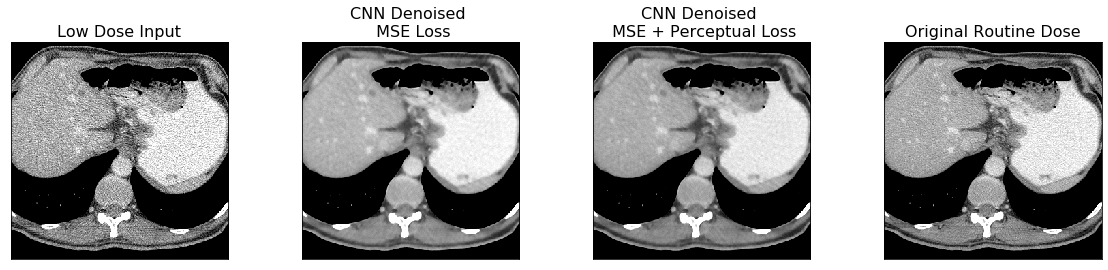

In [0]:
#Cell 17

# Run models on reserved testing data
CNNout_mseloss = denoising_model.predict(test_input)
CNNout_vggloss = model_vggloss.predict(test_input)

# Plot for visual inspection of image quality
buffer = 32
plt.figure(figsize=(20, 4))
plt.subplot(1, 4, 1)
plt.title('Low Dose Input', fontsize=16)
ctshow(test_input[1, buffer:-buffer, buffer:-buffer, 0])

plt.subplot(1, 4, 2)
plt.title('CNN Denoised \n MSE Loss', fontsize=16)
ctshow(CNNout_mseloss[1, buffer:-buffer, buffer:-buffer, 0])

plt.subplot(1, 4, 3)
plt.title('CNN Denoised \n MSE + Perceptual Loss', fontsize=16)
ctshow(CNNout_vggloss[1, buffer:-buffer, buffer:-buffer, 0])

plt.subplot(1, 4, 4)
plt.title('Original Routine Dose', fontsize=16)
ctshow(test_target[1, buffer:-buffer, buffer:-buffer, 0])

## Individualized CNN Denoising

CNN-based noise reduction leverages prior information from the training data to distinguish between noise and anatomic background in CT images. One potential drawback of this approach is that it it may fail when applied to images that are not sufficiently similar to those used during training. 

One way around this issue is to fine-tune the CNN to the anatomic features and typical noise textures for individual patient exams. This can help ensure optimal performance on a case-by-case basis. For more details, see the talk "*Patient-Specific Noise Reduction Using a Deep Convolutional Neural Network*" (SSE24-02) at RSNA this year.  

Some examples using this technique can be seen below. Notice the increased resolution of anatomic features compared to conventional CNN denoising.

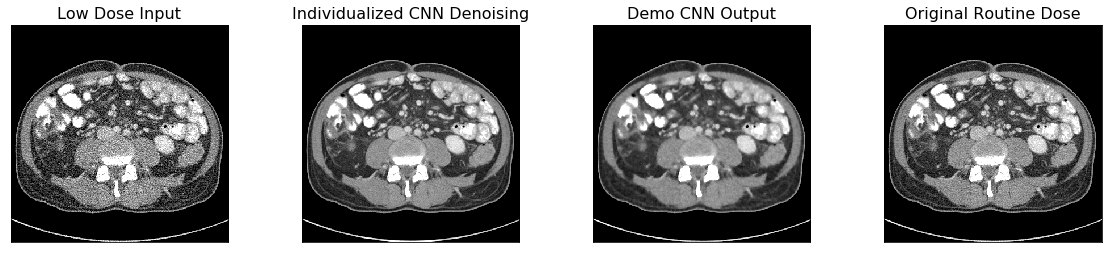

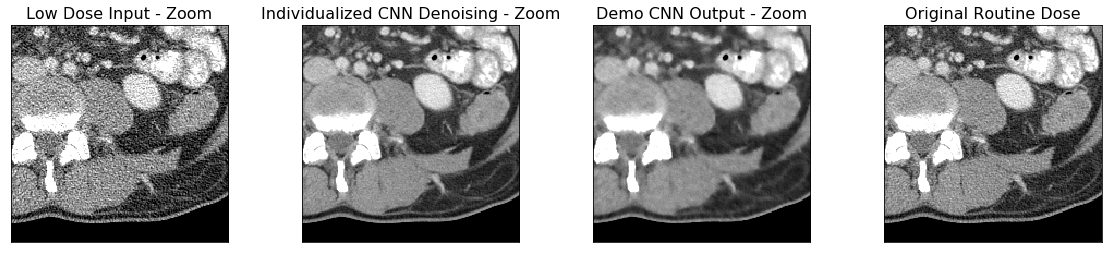

In [0]:
#Cell 18

# Load full quarter dose test image and display result
nexample = 3  

window_width = 400
window_level = 40
vmin = window_level - window_width // 2
vmax = window_level + window_width // 2

plt.figure(figsize=(20, 4))

plt.subplot(1, 4, 1)
plt.title('Low Dose Input', fontsize=16)
ctshow(test_input[nexample, :, :, 0])

plt.subplot(1, 4, 2)
plt.title("Individualized CNN Denoising", fontsize=16)
ctshow(test_example[nexample, :, :, 0])

plt.subplot(1, 4, 3)
plt.title('Demo CNN Output', fontsize=16)
ctshow(CNNout_vggloss[nexample, :, :, 0])

plt.subplot(1, 4, 4)
plt.title('Original Routine Dose', fontsize=16)
ctshow(test_target[nexample, :, :, 0])

# Same as above, but zoomed in to see more details
plt.figure(figsize=(20, 4))
plt.subplot(1, 4, 1)
plt.title('Low Dose Input - Zoom', fontsize=16)
ctshow(test_input[nexample, 150:350, 150:350, 0])

plt.subplot(1, 4, 2)
plt.title('Individualized CNN Denoising - Zoom', fontsize=16)
ctshow(test_example[nexample, 150:350, 150:350, 0])

plt.subplot(1, 4, 3)
plt.title('Demo CNN Output - Zoom', fontsize=16)
ctshow(CNNout_vggloss[nexample, 150:350, 150:350, 0])

plt.subplot(1, 4, 4)
plt.title('Original Routine Dose', fontsize=16)
ctshow(test_target[nexample, 150:350, 150:350, 0])

plt.show()